### Configuration for Transmax streams gateway

In [33]:
import requests
import time
import json
import pandas
session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}

In [26]:
credentials =pandas.read_json("credentials.json")
credentials

,credentials
0,"{'appname': 'testing', 'appid': 'Q56YtQZX205BC..."
1,"{'appname': 'Transmax Streams', 'appid': 'USoL..."


In [46]:
app_id = 'USoLc2B9De86v9QHy5ahcaXkXJd8Fq0a7MCwTI2V'
url='https://api.dtmr.staging.data.streams.com.au'
headers_txt = {'Content-type': 'application/json','x-api-key': 'USoLc2B9De86v9QHy5ahcaXkXJd8Fq0a7MCwTI2V'}

ser_SIMSRecent  = url + "/Incidents/v1/sims"
payload_ser_SIMSRecent = {'size': 5000}    

#-27.419036, 153.072264
#-27.500461, 153.165783
ser_SIMSRecent  = url + "/gis/v1/links"
payload_ser_aggDet = {
        'size':500,
        'from': 1,
        'north': -27.4190,
        'east': 153.0722,
        'south': -27.4191,
        'west': 153.0723
         }   


response = session.get(ser_SIMSRecent,params=payload_ser_SIMSRecent, headers=headers_txt, timeout=600)
response_json = response.json()
#print(response_json)

In [50]:
response_json

{'featureCollection': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'id': '10674026:39:streams.metro.tmr.its',
    'geometry': {'type': 'LineString',
     'coordinates': [[152.945954, -27.53235],
      [152.946006, -27.53251],
      [152.946048, -27.532789],
      [152.946044, -27.533205],
      [152.945962, -27.533537],
      [152.945735, -27.534163]]},
    'properties': {'description': 'Seventeen Mil Seveenteen Mi Sinnamon And SB between Sinnamon And Western Fwy & Seventeen Mile Rks Rd',
     'startIntersectionId': '10674023:50:streams.metro.tmr.its',
     'endIntersectionId': '8483904:50:streams.metro.tmr.its',
     'length': 207,
     'freeFlowSpeed': 50,
     'road': 'Sinnamon Road'}},
   {'type': 'Feature',
    'id': '10674052:39:streams.metro.tmr.its',
    'geometry': {'type': 'LineString',
     'coordinates': [[152.945954, -27.53235],
      [152.946013, -27.532217],
      [152.946091, -27.532006],
      [152.946174061652, -27.5317991294707],
      [152.94

In [56]:
response_json['featureCollection']['features']

[{'type': 'Feature',
  'id': '10674026:39:streams.metro.tmr.its',
  'geometry': {'type': 'LineString',
   'coordinates': [[152.945954, -27.53235],
    [152.946006, -27.53251],
    [152.946048, -27.532789],
    [152.946044, -27.533205],
    [152.945962, -27.533537],
    [152.945735, -27.534163]]},
  'properties': {'description': 'Seventeen Mil Seveenteen Mi Sinnamon And SB between Sinnamon And Western Fwy & Seventeen Mile Rks Rd',
   'startIntersectionId': '10674023:50:streams.metro.tmr.its',
   'endIntersectionId': '8483904:50:streams.metro.tmr.its',
   'length': 207,
   'freeFlowSpeed': 50,
   'road': 'Sinnamon Road'}},
 {'type': 'Feature',
  'id': '10674052:39:streams.metro.tmr.its',
  'geometry': {'type': 'LineString',
   'coordinates': [[152.945954, -27.53235],
    [152.946013, -27.532217],
    [152.946091, -27.532006],
    [152.946174061652, -27.5317991294707],
    [152.94625, -27.53161],
    [152.946262366653, -27.5315418396101],
    [152.946278476299, -27.5314530492383],
    [15

In [ ]:
loop_streams_str = response_json['featureCollection']['features']
loop_list=[]

# for cord in a:
#     lat_long = [cord[1], cord[0]]
#     cord_list.append(lat_long) #= cord[1],cord[0]
# cord_list =[]
q=1
for site in loop_streams_str:
    ## only save sites with more than two coordinates
    if (len(site['geometry']['coordinates']) >1):
        #switch lat long
        new_cord_list =[]
        cord_list =[]
        cord_list = site['geometry']['coordinates']
#         for cord in cord_list:
#             lat_long = [cord[1], cord[0]]
#             new_cord_list.append(lat_long)
        
        case = {'id': site['id'], 'geometry': q, 'road':site['properties']['road'] }
        loop_list.append(case) 


In [245]:
cord[1]

152.866611

In [125]:
geometry=site['geometry']


{'type': 'LineString',
 'coordinates': [[152.866324, -26.623762],
  [152.866428, -26.623172],
  [152.866488, -26.622892],
  [152.866555, -26.622748],
  [152.866611, -26.622678],
  [152.866678, -26.622622],
  [152.866775, -26.622581],
  [152.86688, -26.622555],
  [152.866988, -26.622551],
  [152.867107, -26.622581],
  [152.867249, -26.622685],
  [152.867342, -26.622788],
  [152.867686, -26.623375],
  [152.867771, -26.623479],
  [152.867853, -26.623555],
  [152.867984, -26.623639],
  [152.868163, -26.623742],
  [152.86911, -26.624063],
  [152.870136, -26.624359],
  [152.87077, -26.624401],
  [152.871246, -26.624288],
  [152.871722, -26.624061],
  [152.872292, -26.623579],
  [152.872768, -26.623139],
  [152.873906, -26.62209],
  [152.874307, -26.621764],
  [152.874703, -26.621509],
  [152.875877, -26.621055],
  [152.877342, -26.620549],
  [152.878192, -26.620261],
  [152.878827, -26.620133],
  [152.879829, -26.620134],
  [152.881369, -26.620178]]}

In [122]:
poly={u'type': u'Polygon', u'coordinates': [[[-84.32281494140625, 34.989503567579298], [-84.291229248046875, 35.219819407934352]]]}

In [129]:
#geometry['coordinates'][3]
geometry['coordinates']

[[152.866324, -26.623762],
 [152.866428, -26.623172],
 [152.866488, -26.622892],
 [152.866555, -26.622748],
 [152.866611, -26.622678],
 [152.866678, -26.622622],
 [152.866775, -26.622581],
 [152.86688, -26.622555],
 [152.866988, -26.622551],
 [152.867107, -26.622581],
 [152.867249, -26.622685],
 [152.867342, -26.622788],
 [152.867686, -26.623375],
 [152.867771, -26.623479],
 [152.867853, -26.623555],
 [152.867984, -26.623639],
 [152.868163, -26.623742],
 [152.86911, -26.624063],
 [152.870136, -26.624359],
 [152.87077, -26.624401],
 [152.871246, -26.624288],
 [152.871722, -26.624061],
 [152.872292, -26.623579],
 [152.872768, -26.623139],
 [152.873906, -26.62209],
 [152.874307, -26.621764],
 [152.874703, -26.621509],
 [152.875877, -26.621055],
 [152.877342, -26.620549],
 [152.878192, -26.620261],
 [152.878827, -26.620133],
 [152.879829, -26.620134],
 [152.881369, -26.620178]]

In [138]:
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
import geopandas as gpd
from geopandas import GeoDataFrame

coords = geometry['coordinates']
stick = LineString(coords)


# ax.add_patch(stick_patch)
# x, y = stick.xy
# ax.plot(x, y, 'r-', zorder=1)
# plt.show()

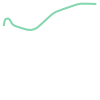

In [135]:
stick

In [141]:
my layer 
#var myLayer = L.geoJSON().addTo(map);

# import mplleaflet
# fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
# plt.plot(stick)
# mplleaflet.display(fig=fig,)

{'type': 'LineString',
 'coordinates': [[152.866324, -26.623762],
  [152.866428, -26.623172],
  [152.866488, -26.622892],
  [152.866555, -26.622748],
  [152.866611, -26.622678],
  [152.866678, -26.622622],
  [152.866775, -26.622581],
  [152.86688, -26.622555],
  [152.866988, -26.622551],
  [152.867107, -26.622581],
  [152.867249, -26.622685],
  [152.867342, -26.622788],
  [152.867686, -26.623375],
  [152.867771, -26.623479],
  [152.867853, -26.623555],
  [152.867984, -26.623639],
  [152.868163, -26.623742],
  [152.86911, -26.624063],
  [152.870136, -26.624359],
  [152.87077, -26.624401],
  [152.871246, -26.624288],
  [152.871722, -26.624061],
  [152.872292, -26.623579],
  [152.872768, -26.623139],
  [152.873906, -26.62209],
  [152.874307, -26.621764],
  [152.874703, -26.621509],
  [152.875877, -26.621055],
  [152.877342, -26.620549],
  [152.878192, -26.620261],
  [152.878827, -26.620133],
  [152.879829, -26.620134],
  [152.881369, -26.620178]]}

In [158]:
from ipyleaflet import Map, Polyline


a= geometry['coordinates']

line = Polyline(
    locations = [[
    [[-26.623762, 152.866324],
 [-26.623172,152.866428]],]],
    color = "green" ,
    fill_color= "green")
m = Map(center = (42.5, -41), zoom =2)
m.add_layer(line)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [252]:
from ipyleaflet import Map

#a= geometry['coordinates']

line = Polyline(
    locations = [[
    cord_list,]],
    color = "green" ,
    fill_color= "green")
m = Map(center = (-26,152), zoom =5)
m.add_layer(line)

m

KeyboardInterrupt: 

In [251]:
cord_list

[[152.866324, -26.623762],
 [152.866428, -26.623172],
 [152.866488, -26.622892],
 [152.866555, -26.622748],
 [152.866611, -26.622678],
 [152.866678, -26.622622],
 [152.866775, -26.622581],
 [152.86688, -26.622555],
 [152.866988, -26.622551],
 [152.867107, -26.622581],
 [152.867249, -26.622685],
 [152.867342, -26.622788],
 [152.867686, -26.623375],
 [152.867771, -26.623479],
 [152.867853, -26.623555],
 [152.867984, -26.623639],
 [152.868163, -26.623742],
 [152.86911, -26.624063],
 [152.870136, -26.624359],
 [152.87077, -26.624401],
 [152.871246, -26.624288],
 [152.871722, -26.624061],
 [152.872292, -26.623579],
 [152.872768, -26.623139],
 [152.873906, -26.62209],
 [152.874307, -26.621764],
 [152.874703, -26.621509],
 [152.875877, -26.621055],
 [152.877342, -26.620549],
 [152.878192, -26.620261],
 [152.878827, -26.620133],
 [152.879829, -26.620134],
 [152.881369, -26.620178],
 [-26.623762, 152.866324],
 [-26.623172, 152.866428],
 [-26.622892, 152.866488],
 [-26.622748, 152.866555],
 [-26